In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR
from torchvision.io import read_image, ImageReadMode
from IPython.display import display
from PIL import Image
from tqdm.auto import tqdm
import timm           # Huggingface Pretrained Models
import imageio        # Saving GIFs
import time 
import os
import wandb
import numpy as np

/home/pokji/anaconda3/envs/cv_pytorch_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
encoder = timm.create_model('timm/vit_small_patch16_dinov3.lvd1689m', pretrained=True, features_only=True)

In [ ]:
example_input = torch.randn(1, 3, 256, 256)
encoder_output = encoder(example_input)
feat_layer1, feat_layer2, feat_layer3 = encoder_output
feat_layer1.shape, feat_layer2.shape, feat_layer3.shape

(torch.Size([1, 384, 16, 16]),
 torch.Size([1, 384, 16, 16]),
 torch.Size([1, 384, 16, 16]))

## Encoder and Decoder Classes

In [3]:
# Example UNet decoder
class ConvDecoder(nn.Module):
    def __init__(self, encoder_dim, out_channels=1):
        super().__init__()

        def up_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True), # Out Dims: [B, out_channels, H*2, W*2]
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), # Out Dims: [B, out_channels, H*2, W*2]
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
            )
        
        self.up1 = up_block(encoder_dim, 128)               # out dims: [B, 128, 32, 32]
        self.up2 = up_block(128, 64)                        # out dims: [B, 64, 64, 64]
        self.up3 = up_block(64, 32)                         # out dims: [B, 32, 128, 128]
        self.up4 = up_block(32, 16)                         # out dims: [B, 16, 256, 256]

        # final head: predict 2 channels -> (delta_raw, mask_logit)
        self.final_conv1 = nn.Conv2d(16, 16, 3, padding=1) # out dims: [B, 16, 256, 256]
        self.final_relu = nn.ReLU(inplace=True)
        # output 2 channels (delta, mask)
        self.final_conv2 = nn.Conv2d(16, 2, 1)               # out dims: [B, 2, 256, 256]

        # zero-init final bias so initial delta/mask ~ 0
        nn.init.zeros_(self.final_conv2.bias)

        # learnable global scale for the delta (starts small)
        self.delta_scale = nn.Parameter(torch.tensor(4.0))

    def forward(self, x):
        x = self.up1(x)
        x = self.up2(x)
        x = self.up3(x)
        x = self.up4(x)
        x = self.final_conv1(x)
        x = self.final_relu(x)
        x = self.final_conv2(x)   # shape: [B, 2, H, W]
        return x


class ViT_UNet_NextFrame(nn.Module):
    def __init__(self, vit_model='vit_small_patch16_224', in_channels=3, out_channels=1):
        super().__init__()

        self.encoder = timm.create_model(vit_model, pretrained=True, features_only=True)
        encoder_channels_dim = self.encoder.feature_info[-1]['num_chs'] # get last feature map channels
        self.decoder = ConvDecoder(encoder_channels_dim, out_channels)
        
        
        # Freeze whole encoder
        for param in self.encoder.parameters():
            param.requires_grad = False

        # Find and unfreeze PatchEmbed robustly
        for name, module in self.encoder.named_modules():
            if module.__class__.__name__ == "PatchEmbed" or "patch_embed" in name:
                for p in module.parameters():
                    p.requires_grad = True
                print("Unfroze patch embed:", name)
                break

        # Unfreeze last block + norm
        for name, p in self.encoder.named_parameters():
            if name.startswith("model.blocks.11."):  # last block
                p.requires_grad = True
                print("Unfroze last block:", name)

    
    def forward(self, x):
        feats = self.encoder(x)[-1]   # last feature map
        out = self.decoder(feats)     # [B,2,H,W]
        delta_raw = out[:, :1, ...]   # raw delta logits
        mask_logit = out[:, 1:2, ...] # mask logits

        # constrained delta + mask
        delta = torch.tanh(delta_raw) * self.decoder.delta_scale
        mask_prob = torch.sigmoid(mask_logit)   # in [0,1]

        return delta, mask_prob

## Dataset Class

In [4]:
class SlidingWindowDataset(Dataset):
    def __init__(self, seq_dirs, input_len=3, pred_len=1, transform=None):
        self.seq_dirs = seq_dirs
        self.input_len = input_len
        self.pred_len = pred_len
        self.window_size = input_len + pred_len
        self.transform = transform

        # collect frame paths and index map
        self.seq_frame_paths = []
        for d in self.seq_dirs:
            files = sorted([f for f in os.listdir(d) if f.endswith('.png')])
            self.seq_frame_paths.append([os.path.join(d, f) for f in files])

        self.index_map = []
        for seq_index, paths in enumerate(self.seq_frame_paths):
            L = len(paths)
            max_start = L - self.window_size + 1
            if max_start > 0:
                for start in range(max_start):
                    self.index_map.append((seq_index, start))

    def __len__(self):
        length = len(self.index_map)
        return length

    def _load_frame(self, path):
        frame = read_image(path, mode=ImageReadMode.GRAY)
        frame = frame.float() / 255.0  # Normalize to [0,1]
        if self.transform is not None:
            frame = self.transform(frame)
        return frame

    def __getitem__(self, idx):
        seq_idx, start_idx = self.index_map[idx]
        paths = self.seq_frame_paths[seq_idx]

        frames = [self._load_frame(paths[i]) for i in range(start_idx, start_idx + self.window_size)]
        input_frame = torch.cat(frames[:self.input_len], dim=0)  # (C=input_len,H,W)
        last_frame = frames[self.input_len - 1]                # (1,H,W)
        target_frame = frames[self.input_len]                  # (1,H,W)

        return input_frame, last_frame, target_frame

## Trainer Class

In [5]:
class Trainer:
    def __init__(self, model, optimizer, criterion, device,
                 scheduler=None, warmup_steps=500, min_lr_fraction=0.0,
                 total_steps=None, clip_grad=None, save_path=None,
                 scheduler_step_per_batch=False,
                 early_stopping_patience=None, early_stopping_min_delta=0.0,
                 early_stopping_restore_best=True, wandb_run=None):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.warmup_steps = warmup_steps
        self.min_lr_fraction = min_lr_fraction
        self.total_steps = total_steps
        self.clip_grad = clip_grad
        self.save_path = save_path
        self.scheduler_step_per_batch = scheduler_step_per_batch
        self.wandb = wandb_run

        self.early_stopping_patience = early_stopping_patience
        self.early_stopping_min_delta = early_stopping_min_delta
        self.early_stopping_restore_best = early_stopping_restore_best

        self.global_step = 0
        self.scheduler = scheduler

    def _save_checkpoint(self, tag="last", is_best=False):
        if not self.save_path:
            return
        state = {
            "model_state": self.model.state_dict(),
            "optim_state": self.optimizer.state_dict(),
            "scheduler_state": self.scheduler.state_dict() if self.scheduler is not None else None,
            "global_step": self.global_step,
        }
        torch.save(state, f"{self.save_path}_{tag}.pt")
        if is_best:
            torch.save(state, f"{self.save_path}_best.pt")

        # after saving file to disk (e.g. in _save_checkpoint)
        if self.wandb and os.path.exists(f"{self.save_path}_{tag}.pt"):
            art = wandb.Artifact(f"model-{run.name}", type="model")
            art.add_file(f"{self.save_path}_{tag}.pt")
            self.wandb.log_artifact(art)


    def load(self, path, map_location=None):
        ckpt = torch.load(path, map_location=map_location)
        self.model.load_state_dict(ckpt["model_state"])
        self.optimizer.load_state_dict(ckpt["optim_state"])
        if self.scheduler is not None and ckpt.get("scheduler_state") is not None:
            try:
                self.scheduler.load_state_dict(ckpt["scheduler_state"])
            except Exception:
                pass
        self.global_step = ckpt.get("global_step", 0)

    
    def _current_lrs(self):
        return [group['lr'] for group in self.optimizer.param_groups]

    @staticmethod
    def _gradient_l1(pred, target):
        dx_p = pred[:, :, :, 1:] - pred[:, :, :, :-1]
        dy_p = pred[:, :, 1:, :] - pred[:, :, :-1, :]
        dx_t = target[:, :, :, 1:] - target[:, :, :, :-1]
        dy_t = target[:, :, 1:, :] - target[:, :, :-1, :]
        return (dx_p - dx_t).abs().mean() + (dy_p - dy_t).abs().mean()

    @staticmethod
    def _tv(x):
        return (x[:, :, :, 1:] - x[:, :, :, :-1]).abs().mean() + (x[:, :, 1:, :] - x[:, :, :-1, :]).abs().mean()
    
    def _train_one_epoch(self, train_loader, epoch, log_every=50):
        self.model.train()
        running_loss = 0.0
        start = time.time()

        loader = tqdm(train_loader, desc=f"Train E{epoch}", leave=False)
        
        for i, (inputs, lasts, targets) in enumerate(loader):
            inputs = inputs.to(self.device)
            lasts = lasts.to(self.device)
            targets = targets.to(self.device)


            self.optimizer.zero_grad()
            delta, mask = self.model(inputs)
            
            pred = lasts * (1.0 - mask) + (lasts + delta) * mask

            target_delta = targets - lasts
            pred_delta = pred - lasts
            delta_loss = F.l1_loss(pred_delta, target_delta)

            motion = target_delta.abs()
            mask_target = (motion > 0.01).float()  # threshold tune
            mask_bce = F.binary_cross_entropy(mask, mask_target)
            
            loss = 2 * delta_loss + 0.2 * mask_bce

            loss.backward()

            total_norm = 0.0
            for p in self.model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** 0.5

            if self.clip_grad is not None:
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_grad)
            self.optimizer.step()

            if self.scheduler is not None and self.scheduler_step_per_batch:
                try:
                    self.scheduler.step()
                except Exception:
                    pass

            self.global_step += 1
            running_loss += loss.item()


            # Log metrics to wandb
            if self.wandb:
                self.wandb.log({
                    "train/loss": loss.item(),
                    "train/mask_mean": mask.mean().item(),
                    "train/delta_mean": delta.abs().mean().item(),
                    "train/delta_std": delta.std().item(),
                    "train/lr": self._current_lrs()[0],
                    "train/grad_norm": total_norm,
                }, step=self.global_step)

            # log example images occasionally (e.g. every 200 steps)
            if self.wandb and (self.global_step % 200 == 0):
                # select first example in batch
                def to_img(t):
                    return (t.squeeze(0).detach().cpu().numpy() * 255).astype("uint8")
                img_last = to_img(lasts[0])
                img_pred = to_img(pred[0])
                img_tgt  = to_img(targets[0])
                self.wandb.log({
                    "train/visuals": [
                        wandb.Image(img_last, caption="last"),
                        wandb.Image(img_pred,  caption="pred"),
                        wandb.Image(img_tgt,   caption="target"),
                    ]
                }, step=self.global_step)


            if (i + 1) % log_every == 0:
                avg = running_loss / float(i + 1)
                lrs = self._current_lrs()
                if len(lrs) == 1:
                    lr_info = f"lr={lrs[0]:.3e}"
                else:
                    lr_info = "lrs=" + ",".join(f"{x:.3e}" for x in lrs)
                loader.set_postfix(loss=f"{avg:.6f}", lr=lr_info)
                print(f"Epoch {epoch} Step {i+1}/{len(train_loader)}  loss={avg:.6f}  {lr_info}")

        elapsed = time.time() - start
        epoch_loss = running_loss / max(1, len(train_loader))
        lrs = self._current_lrs()
        if len(lrs) == 1:
            lr_info = f"lr={lrs[0]:.3e}"
        else:
            lr_info = "lrs=" + ",".join(f"{x:.3e}" for x in lrs)
        print(f"Epoch {epoch} completed in {elapsed:.1f}s  avg_loss={epoch_loss:.6f}  {lr_info}")
        return epoch_loss


    @torch.no_grad()
    def validate(self, val_loader):
        self.model.eval()
        total = 0.0
        count = 0
        for inputs, lasts, targets in tqdm(val_loader, desc="Val", leave=False):
            inputs = inputs.to(self.device)
            lasts = lasts.to(self.device)
            targets = targets.to(self.device)
            delta, mask = self.model(inputs)
            pred = lasts * (1.0 - mask) + (lasts + delta) * mask
            loss = self.criterion(pred, targets)
            total += loss.item()
            count += 1
        return total / max(1, count)

    def fit(self, train_loader, epochs=10, val_loader=None, log_every=50, save_every=1):
        history = {"train_loss": [], "val_loss": []}
        best_val = float('inf')
        best_ckpt = None
        no_improve = 0
        best_epoch = None

        for epoch in range(1, epochs + 1):
            train_loss = self._train_one_epoch(train_loader, epoch, log_every=log_every)
            history["train_loss"].append(train_loss)

            if self.scheduler is not None and not self.scheduler_step_per_batch:
                try:
                    self.scheduler.step()
                except Exception:
                    pass

            if val_loader is not None:
                val_loss = self.validate(val_loader)
                history["val_loss"].append(val_loss)
                print(f"Validation loss: {val_loss:.6f}")


                if self.wandb:
                    self.wandb.log({"val/loss": val_loss}, step=self.global_step)

                improved = (val_loss + self.early_stopping_min_delta) < best_val
                if improved:
                    best_val = val_loss
                    no_improve = 0
                    best_epoch = epoch
                    # save best checkpoint
                    if self.save_path:
                        self._save_checkpoint(tag=f"epoch{epoch}", is_best=True)
                    # keep best state in memory to optionally restore without file IO
                    best_ckpt = {
                        "model_state": self.model.state_dict(),
                        "optim_state": self.optimizer.state_dict(),
                        "scheduler_state": self.scheduler.state_dict() if self.scheduler is not None else None,
                        "global_step": self.global_step,
                    }
                else:
                    no_improve += 1

                if (self.early_stopping_patience is not None) and (no_improve >= self.early_stopping_patience):
                    print(f"Early stopping triggered (no improvement for {no_improve} epochs).")
                    break

            if self.save_path and (epoch % save_every == 0 or epoch == epochs):
                self._save_checkpoint(tag=f"epoch{epoch}")

        if self.save_path:
            self._save_checkpoint(tag="final")

        

        if self.early_stopping_restore_best and best_ckpt is not None:
            try:
                self.model.load_state_dict(best_ckpt["model_state"])
                self.optimizer.load_state_dict(best_ckpt["optim_state"])
                if self.scheduler is not None and best_ckpt.get("scheduler_state") is not None:
                    try:
                        self.scheduler.load_state_dict(best_ckpt["scheduler_state"])
                    except Exception:
                        pass
                print(f"Restored best model from epoch {best_epoch} with val_loss={best_val:.6f}")
            except Exception:
                pass

        return history

### Hyperparameters

In [6]:
LR = 1e-3
BATCH_SIZE = 4
EPOCHS = 20

### Initialize model, criterion and optimizer

In [7]:
# Model, loss, optimizer
model = ViT_UNet_NextFrame(vit_model='timm/vit_small_patch16_dinov3.lvd1689m', in_channels=3, out_channels=1)
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR)

Unfroze patch embed: model.patch_embed


### Split Dataset, Initialize DataLoaders

In [ ]:
import glob
seq_dirs = sorted(glob.glob("bouncing_balls_dataset/seq*"))
len(seq_dirs[:])

100

In [23]:
import glob
import random

seq_dirs = sorted(glob.glob("bouncing_balls_dataset/seq*"))


# deterministic shuffle + split (80/10/10)
random.Random(42).shuffle(seq_dirs)
n = len(seq_dirs)
train_end = int(0.8 * n)
val_end = train_end + int(0.1 * n)

# Split directories
train_dirs = seq_dirs[:train_end]
val_dirs   = seq_dirs[train_end:val_end]
test_dirs  = seq_dirs[val_end:]

# Create datasets
train_ds = SlidingWindowDataset(train_dirs, input_len=3, pred_len=1)
val_ds   = SlidingWindowDataset(val_dirs, input_len=3, pred_len=1)
test_ds  = SlidingWindowDataset(test_dirs, input_len=3, pred_len=1)

# Dataloaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

## Wandb Monitoring

In [10]:
wandb_config = dict(
    batch_size=BATCH_SIZE,
    lr=LR,
    epochs=EPOCHS,
    input_len=3,
)

run = wandb.init(
    project="video-generation-project",
    job_type="train",
    config=wandb_config,
    save_code=True
)

wandb.watch(model, log="all", log_freq=100)

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


# Training

In [11]:
WARMUP_STEPS = len(train_loader) * 1  # 1 epoch warmup
TOTAL_STEPS = EPOCHS * len(train_loader)
MIN_LR = 0.0

warmup_scheduler = LinearLR(optimizer, start_factor=1e-6, total_iters=WARMUP_STEPS)
cosine_scheduler = CosineAnnealingLR(optimizer, T_max=max(1, TOTAL_STEPS - WARMUP_STEPS), eta_min=MIN_LR)
scheduler = SequentialLR(optimizer, schedulers=[warmup_scheduler, cosine_scheduler], milestones=[WARMUP_STEPS])

In [12]:
trainer = Trainer(model, optimizer, criterion, device,
                  scheduler=scheduler, scheduler_step_per_batch=True,
                  clip_grad=1.0, wandb_run=run)

history = trainer.fit(train_loader=train_loader, val_loader=val_loader,
                      epochs=EPOCHS, log_every=20)

Train E1:   0%|          | 0/940 [00:00<?, ?it/s]

NameError: name 'pixel_loss' is not defined

## Testing results

In [ ]:
import cv2
import numpy as np
def generate_recursive(model, init_inputs, steps, device, cv_enhance=False):
    """
    model: your ViT_UNet_NextFrame (expects input shape (B,C,H,W))
    init_inputs: tensor (B,C,H,W) with C = input_len (use unsqueeze(0) for single example)
    steps: number of future frames to generate
    returns: list of predicted frames (as tensors, each (H,W) in [0,1])
    """
    model.eval()
    frames = []
    cur = init_inputs.to(device).clone()

    if cv_enhance:
        kernel = np.ones((2, 2), np.uint8)

    with torch.no_grad():
        for _ in range(steps):
            delta, mask = model(cur)
            last = cur[:, -1:, :, :]
            pred = last * (1.0 - mask) + (last + delta) * mask

            if cv_enhance:
                # morph close on binarized prediction
                pred_np = pred[0,0].detach().cpu().numpy()
                pred_np = cv2.medianBlur(pred_np.astype(np.float32), 3)
                pred_bin = (pred_np > 0.2).astype(np.uint8)
                
                # after pred_bin computed
                num, labels, stats, _ = cv2.connectedComponentsWithStats(pred_bin, connectivity=4)
                # stats: [label, x, y, w, h, area]
                min_area = 200  # tune
                mask = np.zeros_like(pred_bin)
                for i in range(1, num):  # skip background
                    if stats[i, cv2.CC_STAT_AREA] >= min_area:
                        mask[labels == i] = 1
                pred_clean = mask.astype(np.uint8)
    
                pred = torch.from_numpy(pred_clean).float().to(device).unsqueeze(0).unsqueeze(0)

            frames.append(pred[0].squeeze(0).cpu())
            cur = torch.cat([cur[:, 1:, :, :], pred], dim=1)
    return frames


def save_frames_as_gif(frames, path, fps=10, loop=0):
    """
    frames: list of (H,W) tensors in [0,1]
    path: output filepath (e.g. 'pred.gif')
    fps: frames per second
    loop: number of loops (0 = infinite)
    """
    
    out = []
    for frame in frames:
        # Convert tensor to numpy array and scale to [0,255]
        arr = (frame.squeeze().cpu().numpy() * 255).astype('uint8')
        out.append(arr)
    imageio.mimsave(path, out, format='GIF', fps=fps, loop=loop)

### Generate video in notebook

In [ ]:
ckpt = torch.load("model.pt", map_location=device)
model = ViT_UNet_NextFrame(vit_model='timm/vit_small_patch16_dinov3.lvd1689m', in_channels=3, out_channels=1).to(device)
model.load_state_dict(ckpt)
model.eval()

/tmp/ipykernel_6818/3695032471.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("model.pt", map_location=device)


Unfroze patch embed: model.patch_embed
Unfroze last block: model.blocks.11.gamma_1
Unfroze last block: model.blocks.11.gamma_2
Unfroze last block: model.blocks.11.norm1.weight
Unfroze last block: model.blocks.11.norm1.bias
Unfroze last block: model.blocks.11.attn.qkv.weight
Unfroze last block: model.blocks.11.attn.proj.weight
Unfroze last block: model.blocks.11.attn.proj.bias
Unfroze last block: model.blocks.11.norm2.weight
Unfroze last block: model.blocks.11.norm2.bias
Unfroze last block: model.blocks.11.mlp.fc1.weight
Unfroze last block: model.blocks.11.mlp.fc1.bias
Unfroze last block: model.blocks.11.mlp.fc2.weight
Unfroze last block: model.blocks.11.mlp.fc2.bias


In [40]:
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

steps = 25
idx = 500
init_input, _, _ = test_ds[idx]

frames = generate_recursive(model, init_input.unsqueeze(0), steps, device, cv_enhance=True)

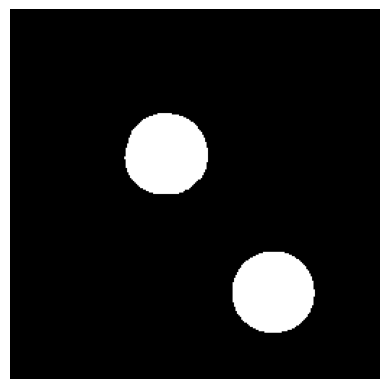

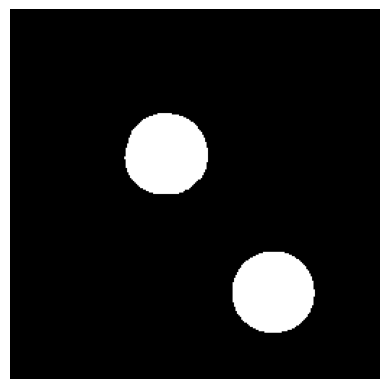

In [41]:
for frame in frames[:100]:
    clear_output(wait=True)
    plt.imshow(frame.squeeze(0), cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    display(plt.gcf())
    plt.pause(0.03)

### Save to gif

In [ ]:
save_frames_as_gif(frames, "predicted.gif", fps=10)